# Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import numpy as np
from transformers import AutoModel 
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments
import evaluate
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import pipeline  

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


text          0
label         0
label_name    0
dtype: int64

In [4]:
df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

## Dataset Analysis

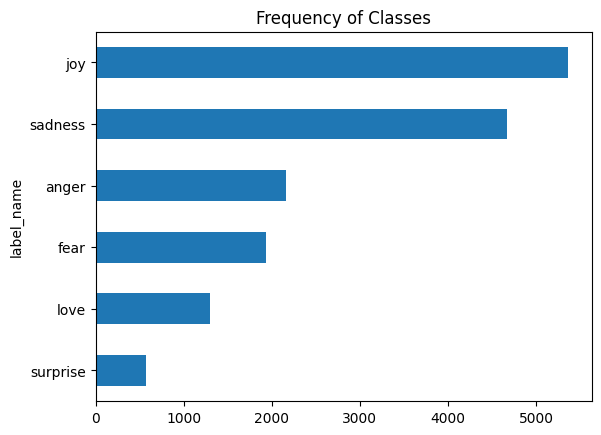

In [5]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

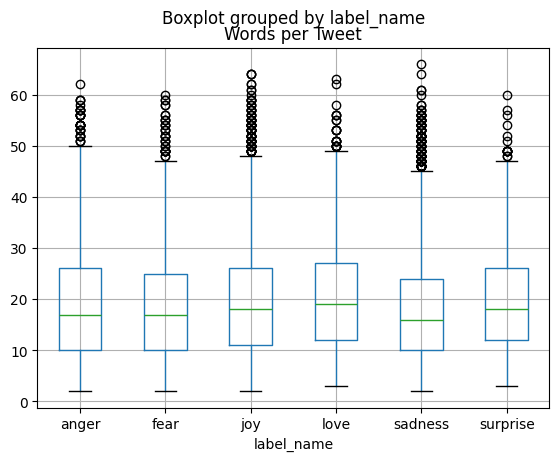

In [6]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name")
plt.show()

In [7]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)

# Get token ids
input_ids = encoded_text["input_ids"]

# Convert ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Show tokens with their IDs
for token, token_id in zip(tokens, input_ids):
    print(f"{token:<15} --> {token_id}")


[CLS]           --> 101
i               --> 1045
love            --> 2293
machine         --> 3698
learning        --> 4083
!               --> 999
token           --> 19204
##ization       --> 3989
is              --> 2003
awesome         --> 12476
!               --> 999
!               --> 999
[SEP]           --> 102


In [8]:
# Get the vocabulary size directly
vocab_size = tokenizer.vocab_size

# Get the maximum sequence length this model supports
max_length = tokenizer.model_max_length

# Print all values together for comparison
print(f'Vocabulary size of the tokenizer : {vocab_size}')
print(f'Maximum sequence length this model supports : {max_length}')


Vocabulary size of the tokenizer : 30522
Maximum sequence length this model supports : 512


## Data Loader and Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Check the shape of the full dataset (rows, columns)
print("Full dataset shape:", df.shape)

# Display the first few rows to get a quick look at the data
print(df.head())

# Split the dataset into:
#  - 70% training data
#  - 30% temporary data (to be further split into test + validation)
train, temp = train_test_split(
    df,
    test_size=0.3,                      # 30% of the data goes into temp
    stratify=df['label_name'],          # stratify ensures balanced class distribution
    random_state=42                     # for reproducibility
)

# Split the temporary set into:
#  - 50% test
#  - 50% validation
# (Since temp = 30% of full data → each becomes 15%)
test, validation = train_test_split(
    temp,
    test_size=0.5,                      # half of temp goes to validation
    stratify=temp['label_name'],        # maintain class distribution
    random_state=42
)

# Display the final shapes of each dataset
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Validation shape:", validation.shape)


Full dataset shape: (16000, 4)
                                                text  label label_name  \
0                            i didnt feel humiliated      0    sadness   
1  i can go from feeling so hopeless to so damned...      0    sadness   
2   im grabbing a minute to post i feel greedy wrong      3      anger   
3  i am ever feeling nostalgic about the fireplac...      2       love   
4                               i am feeling grouchy      3      anger   

   Words per Tweet  
0                4  
1               21  
2               10  
3               18  
4                4  
Train shape: (11200, 4)
Test shape: (2400, 4)
Validation shape: (2400, 4)


In [10]:
from datasets import Dataset, DatasetDict

# Convert pandas DataFrames (train, test, validation) into Hugging Face Dataset objects
# `preserve_index=False` removes the old pandas index to avoid an extra column in the dataset
dataset = DatasetDict({
    'train': Dataset.from_pandas(train, preserve_index=False),        # Training split
    'test': Dataset.from_pandas(test, preserve_index=False),          # Test split
    'validation': Dataset.from_pandas(validation, preserve_index=False) # Validation split
})

# Display dataset information (splits, number of rows, features, etc.)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 2400
    })
})


## Tokenization of the Emotion/Sentiment Data

In [11]:
# Access the first training example (row 0)
first_sample = dataset['train'][0]

# Access the second training example (row 1)
second_sample = dataset['train'][1]

# Print them to inspect the structure (dict with feature: value)
print("First training sample:", first_sample)
print("Second training sample:", second_sample)

First training sample: {'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it', 'label': 0, 'label_name': 'sadness', 'Words per Tweet': 25}
Second training sample: {'text': 'i was feeling brave when i bought it and clearly when i was doing my makeup', 'label': 1, 'label_name': 'joy', 'Words per Tweet': 16}


In [12]:
# Define a function to tokenize a batch of text data
def tokenize(batch):
    # Tokenize the 'text' column from the dataset
    # - padding=True → pad sequences to the same length in a batch
    # - truncation=True → cut off sequences longer than model_max_length
    tokenized_output = tokenizer(
        batch['text'],
        padding=True,
        truncation=True
    )
    return tokenized_output

# Tokenize the first 2 samples from the training dataset
print(tokenize(dataset['train'][0])['input_ids'])


[101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102]


In [13]:
# Apply the tokenize() function to the entire dataset
# - batched=True → process multiple samples together for efficiency
# - batch_size=None → let the tokenizer decide the batch size automatically
# The result will add new columns like 'input_ids', 'attention_mask', etc.
emotion_encoded = dataset.map(
    tokenize,
    batched=True,
    batch_size=None
)

# Inspect the processed dataset
print(emotion_encoded)


Map: 100%|██████████| 2400/2400 [00:00<00:00, 26931.23 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2400
    })
})


In [14]:
# Create a mapping from label name → label id
# Example: {"positive": 0, "negative": 1, ...}
label2id = {
    sample['label_name']: sample['label']
    for sample in dataset['train']
}

# Create the reverse mapping: label id → label name
# Example: {0: "positive", 1: "negative", ...}
id2label = {
    v: k
    for k, v in label2id.items()
}

# Print both dictionaries
print("Label → ID mapping:", label2id)
print("ID → Label mapping:", id2label)


Label → ID mapping: {'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}
ID → Label mapping: {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'}


## Model Building

In [15]:
# Load a pretrained model from Hugging Face Hub
# - model_ckpt should be a string like "bert-base-uncased"
# - AutoModel loads only the base model (without any task-specific head)
model = AutoModel.from_pretrained(model_ckpt)

# Inspect the model architecture
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [16]:
# Get the mapping from label IDs → label names (if available in the model config)
print("ID to Label mapping:", model.config.id2label)

# Print the full model configuration
# This includes hidden size, number of layers, vocab size, max sequence length, etc.
print("Model configuration:\n", model.config)

ID to Label mapping: {0: 'LABEL_0', 1: 'LABEL_1'}
Model configuration:
 BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Fine-Tuning Transformers

In [17]:
# Get the number of unique labels from your dataset
num_labels = len(label2id)
print("Number of labels:", num_labels)

# Set the device to GPU (if available) or fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model configuration with custom label mappings
# - label2id: maps label names → ids
# - id2label: maps ids → label names
config = AutoConfig.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    num_labels=num_labels       # make sure config knows number of labels
)

# Load a pretrained model for sequence classification
# - Uses your config (so model knows about your labels)
# - Automatically adds a classification head on top of the base model
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    config=config
).to(device)   # Move model to GPU/CPU


Number of labels: 6
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Print the full configuration of the model
# This shows hyperparameters like:
# - hidden_size, num_attention_heads, num_hidden_layers
# - vocab_size, max_position_embeddings
# - num_labels (important for classification tasks)
# - label2id / id2label mappings (your custom mappings)
print(model.config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [19]:
# Define batch size
batch_size = 64

# Directory where model checkpoints and logs will be saved
training_dir = "bert_base_train_dir"

# Define training arguments for the Trainer API
training_args = TrainingArguments(
    output_dir=training_dir,              # where to save model checkpoints
    overwrite_output_dir=True,            # overwrite contents if the dir exists
    num_train_epochs=2,                   # number of training epochs
    learning_rate=2e-5,                   # Adam optimizer learning rate
    per_device_train_batch_size=batch_size, # batch size per GPU/CPU during training
    per_device_eval_batch_size=batch_size, # batch size per GPU/CPU during evaluation
    weight_decay=0.01,                    # strength of weight decay regularization
    eval_strategy="epoch",          # run evaluation at the end of each epoch
    disable_tqdm=False                    # whether to show progress bars
)


In [20]:
# Load the accuracy metric from Hugging Face's 'evaluate' library
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics
def compute_metrics_evaluate(eval_pred):
    # eval_pred is a tuple: (model_predictions, true_labels)
    predictions, labels = eval_pred
    
    # Convert raw prediction logits → predicted class IDs
    predictions = np.argmax(predictions, axis=1)
    
    # Compute accuracy by comparing predicted vs. true labels
    return accuracy.compute(predictions=predictions, references=labels)

In [21]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.55.3', '1.10.0')

In [22]:
# use sklearn to build compute metrics


from sklearn.metrics import accuracy_score, f1_score

# Define a function to compute multiple evaluation metrics
def compute_metrics(pred):
    # Extract true labels and predicted logits
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)   # convert logits → predicted class IDs

    # Compute weighted F1-score (accounts for class imbalance)
    f1 = f1_score(labels, preds, average="weighted")

    # Compute accuracy (overall correct predictions)
    acc = accuracy_score(labels, preds)

    # Return both metrics in a dictionary
    return {
        "accuracy": acc,
        "f1": f1
    }



## Build Model and Trainer

In [23]:
from transformers import Trainer

# Initialize the Hugging Face Trainer
trainer = Trainer(
    model=model,                        # the model to train (with classification head)
    args=training_args,                 # training configuration (epochs, batch size, etc.)
    compute_metrics=compute_metrics,    # function to compute evaluation metrics (accuracy, f1)
    train_dataset=emotion_encoded['train'],   # tokenized training dataset
    eval_dataset=emotion_encoded['validation'], # tokenized validation dataset
    tokenizer=tokenizer                 # tokenizer (needed for saving/loading + padding info)
)


C:\Users\JITHIN\AppData\Local\Temp\ipykernel_30676\1911620533.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
# Start training the model using the Trainer API
# - Uses the training dataset (emotion_encoded['train'])
# - Runs evaluation on the validation dataset after each epoch (as per training_args)
# - Logs metrics like loss, accuracy, and f1
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.411656,0.872500,0.863705
2,No log,0.242898,0.921250,0.920621


TrainOutput(global_step=350, training_loss=0.7093024117606027, metrics={'train_runtime': 503.9485, 'train_samples_per_second': 44.449, 'train_steps_per_second': 0.695, 'total_flos': 1001502421516800.0, 'train_loss': 0.7093024117606027, 'epoch': 2.0})

## Model Evaluation

In [26]:
# Run prediction on the test dataset
# This returns a PredictionOutput object containing:
# - predictions (raw logits)
# - label_ids (true labels)
# - metrics (evaluation results like accuracy, f1)
preds_output = trainer.predict(emotion_encoded['test'])

# Print only the evaluation metrics (accuracy, f1, loss, etc.)
print(preds_output.metrics)

{'test_loss': 0.28809601068496704, 'test_accuracy': 0.8991666666666667, 'test_f1': 0.8987377356180104, 'test_runtime': 16.7573, 'test_samples_per_second': 143.221, 'test_steps_per_second': 2.268}


In [27]:
# Convert raw logits from model predictions into class IDs
# - argmax(axis=1) picks the class with the highest probability for each sample
y_pred = np.argmax(preds_output.predictions, axis=1)

# Extract the true labels from the test dataset
# - [:] means get all rows
# - ['label'] selects the label column
y_true = emotion_encoded['test'][:]['label']

print("Predicted labels:", y_pred[:10])  # show first 10 predictions
print("True labels:", y_true[:10])      # show first 10 true labels


Predicted labels: [1 4 0 0 3 3 1 1 2 0]
True labels: [1, 4, 0, 0, 4, 3, 1, 1, 2, 0]


In [30]:
# Generate a detailed classification report
# Includes precision, recall, f1-score for each class
# Also shows macro avg, weighted avg, and overall accuracy
report = classification_report(y_true, y_pred)

print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       700
           1       0.92      0.92      0.92       804
           2       0.78      0.76      0.77       195
           3       0.90      0.90      0.90       324
           4       0.86      0.90      0.88       291
           5       0.84      0.72      0.78        86

    accuracy                           0.90      2400
   macro avg       0.87      0.86      0.86      2400
weighted avg       0.90      0.90      0.90      2400



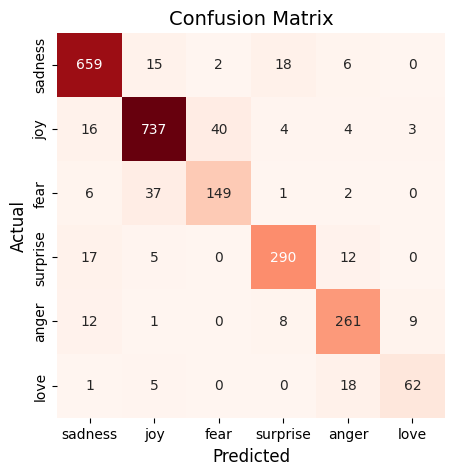

In [33]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,                         # show counts in each cell
    fmt='d',                            # integer formatting
    cmap='Reds',                        # red color map
    cbar=False,                         # hide color bar
    xticklabels=label2id.keys(),        # predicted labels
    yticklabels=label2id.keys()         # actual labels
)

# Axis labels
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.show()


## Build Prediction Function and Store Model

In [34]:
def get_prediction(text):
    # tokenize input and move tensors to device (CPU/GPU)
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    # run inference without computing gradients
    with torch.no_grad():
        outputs = model(**input_encoded)

    # extract logits (raw scores for each class)
    logits = outputs.logits

    # take the index of the highest scoring class
    pred = torch.argmax(logits, dim=1).item()

    # map index back to human-readable label
    return id2label[pred]

# Example usage
text = "I am super happy today. I got it done. Finally!!"
print(get_prediction(text))

joy


In [35]:
# Save the fine-tuned model, tokenizer, and config files into the folder 
# "bert-base-uncased-sentiment-model" so it can be reloaded or shared later
trainer.save_model("bert-base-uncased-sentiment-model")



In [39]:
# Load the fine-tuned model from the saved folder ("bert-base-uncased-sentiment-model") 
# and create a text-classification pipeline for sentiment prediction
classifier = pipeline('text-classification', model='bert-base-uncased-sentiment-model')

# Run predictions on multiple text inputs at once
# The pipeline will return the predicted labels and confidence scores for each text
sentences = [text, 'hello, how are you?', "love you", "i am feeling low"]
for sent in sentences:
    print(f'{sent} ---> {classifier(sent)[0]['label']}')



Device set to use cuda:0


I am super happy today. I got it done. Finally!! ---> joy
hello, how are you? ---> joy
love you ---> love
i am feeling low ---> sadness
